In [142]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
#import plotly.express as px
#import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from urllib.parse import unquote

In [143]:
articles =  pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"], skiprows=12)

In [144]:
links = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt("data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)
categories= pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=["article", "category"], skiprows = 13)

In [145]:
# Translating all article titles to user readable format

articles['article'] = articles['article'].apply(unquote)
links['link_source'] = links['link_source'].apply(unquote)
links['link_target'] = links['link_target'].apply(unquote)
paths_finished['path'] = paths_finished['path'].apply(unquote)
paths_unfinished['path'] = paths_unfinished['path'].apply(unquote)
paths_unfinished['target'] = paths_unfinished['target'].apply(unquote)
categories['article'] = categories['article'].apply(unquote)

In [6]:
# seperate each row and create a matrix with all the shortest distance

table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_text])

table_distance

array([[ 0, -1, -1, ...,  4,  4,  2],
       [-1,  0, -1, ...,  3,  3,  3],
       [-1, -1,  0, ...,  3,  3,  3],
       ...,
       [-1, -1, -1, ...,  0,  3,  3],
       [-1, -1, -1, ...,  4,  0,  3],
       [-1, -1, -1, ...,  3,  3,  0]])

In [7]:
def seperate_path(path):

    # Split the path into individual articles
    articles = path.split(";")
    
    # Extract source and target
    source, target = articles[0], articles[-1]
    
    # Calculate the length, considering back-clicks
    length = len(articles) + articles.count('') - 1
    
    return source, target, length


In [8]:
# expand the finished paths
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]
                                                                       



In [9]:
# Find the index of an article in the helper DataFrame
def find_article_index(article, helper_df):
    try:
        return helper_df.loc[article]
    except KeyError:
        return None

# Calculate the shortest distance between source and target indices
def calculate_shortest_distance(source_idx, target_idx):
    try:
        return table_distance[source_idx, target_idx][0]
    except KeyError:
        return None

# Finding the shortest path length between a source and a target
def find_path_distance(source, target, helper_df):
    source_idx = find_article_index(source, helper_df)
    target_idx = find_article_index(target, helper_df)

    if source_idx is not None and target_idx is not None:
        return calculate_shortest_distance(source_idx, target_idx)
    else:
        # Handle the case where source or target is not present in the index
        return None  # You can customize this behavior based on your specific needs



In [10]:
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: find_path_distance(row['source'], row['target'], help_articles), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

In [11]:
#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))

# Translating article names from URL to latin characters
path_overview['source'].apply(unquote)
path_overview['target'].apply(unquote)

display(path_overview)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type
0,14th_century,African_slave_trade,6a3701d319fc3754,1297740409,3.0,166,8,True,NaN,NaN
1,14th_century,African_slave_trade,3824310e536af032,1344753412,3.0,88,4,True,3.0,NaN
2,14th_century,African_slave_trade,415612e93584d30e,1349298640,3.0,138,7,True,NaN,NaN
3,14th_century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN
4,14th_century,John_F._Kennedy,015245d773376aab,1366730828,3.0,175,6,True,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,109ed71f571d86e9,1389787605,3.0,180,7,False,NaN,restart
76189,Modern_history,Hollandic,232f992e57d43e8d,1389787697,3.0,6,0,False,NaN,restart
76190,Computer_programming,The_Beatles,2e09a7224600a7cd,1389798400,3.0,1900,4,False,NaN,timeout
76191,Jamaica,Alan_Turing,60af9e2138051b96,1389799481,3.0,1903,3,False,NaN,timeout


In [21]:
# extract categories
def extract_subject_category(category):
    # Split the category string by '.'
    category_parts = category.split('.')
    
    # Find the index of 'subject' in the split parts
    subject_index = category_parts.index('subject')
    
    # Check if there is at least one word after 'subject'
    if subject_index < len(category_parts) - 1:
        return category_parts[subject_index + 1]

# Apply the custom function to create a new 'subject_category' column
categories['subject_category'] = categories['category'].apply(extract_subject_category)

# Create a new DataFrame with only the relevant columns
main_categories = categories[['article', 'subject_category']]

# Display the new DataFrame
main_categories.head()

,article,subject_category
0,Áedán_mac_Gabráin,History
1,Áedán_mac_Gabráin,People
2,Åland,Countries
3,Åland,Geography
4,Édouard_Manet,People


In [15]:
# Below we find the articles which have different names to those outlined in the UN dataset. We then manually found the corresponding name in the UN
# dataset and created a dictionary to map article names -> UN dataset name

countries = main_categories[main_categories['subject_category'] == 'Countries']['article'].values
UN_countries = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')

countries_missing = []

for country in countries:
    country = country.replace('_',' ')
    if country not in UN_countries['Country or Area'].values:
        countries_missing.append(country)

replacement_country_names = [
    'Åland Islands', 'Ireland', 'Georgia', 'United Arab Emirates', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia', 'United Arab Emirates',
    'Timor-Leste', 'Chile', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'Ecuador', 'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', 'Republic of Korea', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine', 'China', 'China', 'Ireland',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'China', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'China', 'Türkiye', 'Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

replacement_countries = dict(zip(countries_missing, replacement_country_names))

In [17]:
def get_region(country):
    """
    Returns the region for country, using replacement_countries for those with different names in the UN dataset
    """
    country = country.replace('_',' ')
    if country in UN_countries['Country or Area'].values:
        region = UN_countries[UN_countries['Country or Area'] == country]['Region Name'].values
        # print(type(region))
        return region[0]
    else:
        new_country = replacement_countries[country]
        region = UN_countries[UN_countries['Country or Area'] == new_country]['Region Name'].values
        if len(region) > 0:
            return region[0]
        else:
            return ""

In [60]:
# Creating a dictionary to map each country to its continent (region).

country_to_region = {}

for country in countries:
    country_to_region[country] = get_region(country)

# 'Kosovo' and 'South_Ossetia' are added manually as they are not present in the UN dataframe.
country_to_region['Kosovo'] = 'Europe'
country_to_region['South_Ossetia'] = 'Asia'

df_country_region = pd.DataFrame.from_dict(country_to_region, 
                                           orient='index',
                                           dtype=None,
                                           columns=['region'])

df_country_region.reset_index(inplace=True)
df_country_region.rename(columns={"index": "article"}, inplace=True)

Text(0, 0.5, 'Count')

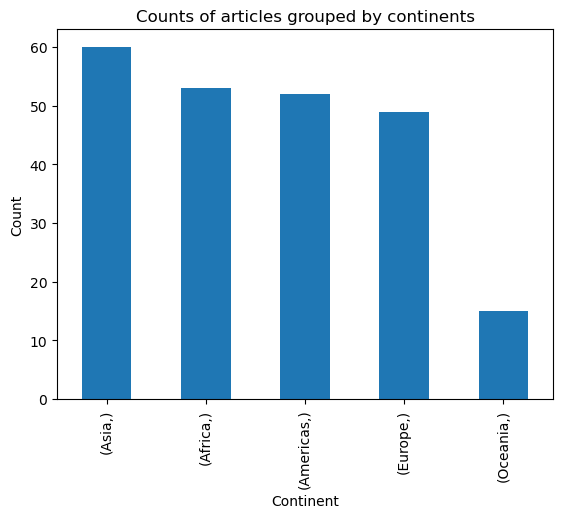

In [20]:
# Plotting the distribution of countries in the dataset based on their continent, which we will consider their region.

continents_count = pd.DataFrame(country_to_region.values()).value_counts()

continents_count.plot(kind='bar')
# plt.xticks(['Asia','Africa','Americas','Europe','Oceania'])

plt.title("Counts of articles grouped by continents")
plt.xlabel("Continent")
plt.ylabel("Count")

## First research questions

### Summary statistics for the number of in- and out- degrees of each region 

In [ ]:
links_outdegree = links.copy()
links_outdegree.columns = ['article','link_out']
out_degrees = links_outdegree.groupby('article').count()
out_degrees.sort_values(by='link_out', ascending=False, inplace=True)

links_indegree = links.copy()
links_indegree.columns = ['link_in','article']
in_degrees = links_indegree.groupby('article').count()
in_degrees.sort_values(by='link_in', ascending=False, inplace=True)

link_counts = out_degrees.merge(in_degrees, how='outer', on='article')
link_counts

,link_out,link_in
article,,
United_States,294.0,1551.0
Driving_on_the_left_or_right,255.0,NaN
List_of_countries,244.0,63.0
List_of_circulating_currencies,236.0,8.0
List_of_sovereign_states,216.0,43.0
...,...,...
Osteomalacia,NaN,3.0
Directdebit,NaN,2.0
Klinefelter's_syndrome,NaN,1.0


In [92]:
country_links = link_counts[link_counts.index.isin(countries)]
country_links.reset_index(inplace=True)
country_links = country_links.merge(df_country_region, on='article', how='left')

In [93]:
# Initialising empty dataframes
link_out_summary = pd.DataFrame()
link_in_summary = pd.DataFrame()

# Getting summary statistics for each region for in- and out- degrees
links_means = country_links.groupby(['region']).mean()
links_std = country_links.groupby(['region']).std()
links_max = country_links.groupby(['region']).max()
links_median = country_links.groupby(['region']).median()

for df, kind in [(links_means, 'mean'), (links_median, 'median'), (links_std, "std"), (links_max, 'max')]:
    link_out_summary[kind] = df['link_out']
    link_in_summary[kind] = df['link_in']

In [94]:
display(link_in_summary)

,mean,median,std,max
region,,,,
Africa,81.415094,67.0,56.970449,362.0
Americas,103.098039,46.0,225.440392,1551.0
Asia,118.016667,83.0,119.882498,611.0
Europe,208.191489,110.0,225.054741,972.0
Oceania,83.600000,31.0,150.264434,563.0


In [95]:
display(link_out_summary)

,mean,median,std,max
region,,,,
Africa,62.830189,39.0,46.279558,162.0
Americas,46.019231,37.5,42.885388,294.0
Asia,61.450000,45.5,46.840669,192.0
Europe,71.816327,58.0,39.994621,169.0
Oceania,35.533333,28.0,22.487669,86.0


## Second section of research questions

### Finished paths and target countries

In [103]:
country_path_overview = path_overview[path_overview['target'].isin(countries)]

country_path_overview = country_path_overview.merge(df_country_region, 
                                                    left_on='target', 
                                                    right_on='article', 
                                                    how='left').drop(['article'], axis=1)

In [125]:
region_completed_count = country_path_overview[['region','completed','target']].groupby(['region','completed']).count()
region_count = country_path_overview[['region','target']].groupby(['region']).count()
# region_completed_count.set_index(['region'], inplace=True)
region_count

,target
region,
Africa,857
Americas,989
Asia,1557
Europe,1141
Oceania,201


In [141]:
proportions = pd.DataFrame()

for region, completion in region_completed_count.index:
    proportion = region_completed_count.loc[(region, completion)] / region_count.loc[region]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")

Proportion of unfinished paths with Africa as target: 11.4352%
Proportion of finished paths with Africa as target: 88.5648%
Proportion of unfinished paths with Americas as target: 15.6724%
Proportion of finished paths with Americas as target: 84.3276%
Proportion of unfinished paths with Asia as target: 11.8176%
Proportion of finished paths with Asia as target: 88.1824%
Proportion of unfinished paths with Europe as target: 8.9395%
Proportion of finished paths with Europe as target: 91.0605%
Proportion of unfinished paths with Oceania as target: 25.3731%
Proportion of finished paths with Oceania as target: 74.6269%


### Length of pathway analysis

In [147]:
country_path_overview

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type,region
0,14th_century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN,Europe
1,2005_Atlantic_hurricane_season,Spain,0d57c8c57d75e2f5,1287268005,1.0,22,3,True,1.0,NaN,Europe
2,2005_Atlantic_hurricane_season,Liechtenstein,0ec465e516314a56,1249908585,2.0,391,5,True,2.0,NaN,Europe
3,2005_Atlantic_hurricane_season,Liechtenstein,1dbbba9e540a9b9b,1346912342,2.0,227,2,True,5.0,NaN,Europe
4,2005_Atlantic_hurricane_season,Sweden,2134400014dd016d,1366612470,2.0,53,4,True,NaN,NaN,Europe
...,...,...,...,...,...,...,...,...,...,...,...
4740,Proton,Liechtenstein,1c495c3c72396b19,1388389488,3.0,96,2,False,NaN,restart,Europe
4741,Scotland_in_the_High_Middle_Ages,Jamaica,405a17d643fa8160,1388625809,2.0,1809,0,False,NaN,timeout,Americas
4742,Vanadium,Latvia,580bea917fbb4ced,1389370284,2.0,52,0,False,NaN,restart,Europe
4743,Literacy,Kyrgyzstan,23f7c6281660209f,1389494317,2.0,679,17,False,NaN,restart,Asia
